In [1]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests


# Spivakov ILC3 and CD4+ T cell Analysis Rerun

This notebook will walk through the analysis of pcHi-C data generated by Mikhail Spivakov's group. We will also analyze CD4+ alpha-beta T-cells in addition to the ILC3 data as a positive control sample.

There are two parts to this analysis. The sections are as follows:

## Data Overview

We have two cell types to analyze:

* Human Tonsil ILC3
* Human Venous Blood CD4+ alpha/beta T-cells

These two cell types were analyzed with two different analysis methods:

* 5kb bin level - interactions are approximately 5k bins instead of the size of restriction fragments
* fragment level - interactions are the size of the restriction fragment made by DPNII
  
For the following analysis we remove transchromosomal interactions and off-target interactions.

## Preliminary set up

In [2]:
cd /Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/p2p/RELI_results_GWAS_763phenotypes_hg19/

/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/p2p/RELI_results_GWAS_763phenotypes_hg19


In [9]:
!pwd

/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/data/pchic


In [10]:
output_dir = "/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/p2p/PIR"

In [11]:
class ChicagoData(object):
    """Import CHICACO data
    """
    def __init__(self,
                 filename: str,
                 dropna: bool = True,
                 drop_off_target: bool = True,
                 drop_trans_chrom: bool = True,
                 score_col: str = None
                 ):
        """Initialize the object

        Args:
            filename (str): input CHICAGO txt file
            dropna (bool, optional): Drop the interactions with NA. Defaults to =True.
            drop_off_target (bool, optional): Drop off target interactions. Defaults to =True.
            drop_trans_chrom (bool, optional): Drop transchromosomal interactions. Defaults to =True.
        """
        # Set filename to the input filename
        self.filename = filename
        # Set whether to drop na interactions
        self.dropna = dropna
        # Set whether to drop off target
        self.drop_off_target = drop_off_target
        # Set whether to drop promoter promoter interactions
        self.drop_p2p = drop_p2p
        # Set whether to drop transchromosomal interactions
        self.drop_trans_chrom = drop_trans_chrom
        # Score column name for filtering
        self.score_col = score_col
        
        # Read file into DF
        self._read_file_()
        
        # Format the DF
        self._format_file_()
        
        # Filter the formatted DF
        self._filter_file_()

        # Get the PIR df
        self._get_PIR_df_()
        
    def _read_file_(self):
        """Read in original file
        """
        # Read in original file and save
        self.input_df =  pd.read_csv(self.filename, sep="\t", header=0, low_memory=False)
    
    def _format_file_(self):
        """Format CHICAGO file
        """
        # Create a copy of the raw input to be manipulated
        df = self.input_df.copy()
        
        # Format the chromosome names
        df["baitChr"] = "chr" + df["baitChr"].apply(str)
        df["oeChr"] = "chr" + df["oeChr"].apply(str)
        
        # Calculate the wide of the intervals
        df["OE_width"] = df["oeEnd"] - df["oeStart"]
        
        # Create an ID column that can be used to track the intervals
        df["ID"] = df["baitChr"] + ":" + \
                   df["baitStart"].apply(str) + "-" + \
                   df["baitEnd"].apply(str) + "_" + \
                   df["oeChr"] + ":" + \
                   df["oeStart"].apply(str) + "-" + \
                   df["oeEnd"].apply(str)

        # Set the variable to the formatted df
        self.df = df
    
    def _filter_file_(self):
        """Filter the formatted CHICAGO results
        """
        if self.dropna:
            self.df.dropna(subset=["dist"], inplace=True)

        if self.drop_off_target:
            self.df[self.df["baitName"] != "off_target"]

        if self.drop_trans_chrom:
            self.df = self.df[self.df["baitChr"] == self.df["oeChr"]]
        
        if self.score_col:
            self.df = self.df[self.df[self.score_col] >= 5]

        
    def _get_PIR_df_(self):
        """Get a DF of all PIR interactions
        """
        self.pir_df = self.df[["oeChr", "oeStart", "oeEnd", "OE_width"]].drop_duplicates(subset=["oeChr", "oeStart", "oeEnd"], keep="first")

    def write_PIR_bed(self, output_filename): 
        """Write PIRs from the filtered CHICAGO results to a bed file
        """       
        self.pir_df.to_csv(output_filename, sep="\t", header=False, index=False)
        
    
        

## Getting PIRs From CHICAGO

For this analysis we included the promoter-to-promoter interactions and excluded trans-chromosomal interactions.

### ILC3


#### DpnII

In [13]:
ILC_frag_df = ChicagoData("hILC3_merged_fragres_wnew_score5.txt", score_col="hILC3_merged_fragres_wnew")

ILC_frag_df.write_PIR_bed(os.path.join(output_dir, "hILC3_10K_dpnII_fragments_PIR.bed"))

ILC_5kbin_df = ChicagoData("hILC3_merged_bin5K_score5.txt", score_col="hILC3_merged_bin5k")

ILC_5kbin_df.write_PIR_bed(os.path.join(output_dir, "hILC3_10K_dpnII_5kbin_PIR.bed"))

### CD4

#### DpnII

In [14]:
CD4_K50_frag_df = ChicagoData("CD4_1M_50K_merged_reweighting_peakmatrix_score5.txt", score_col="K50")

CD4_K50_frag_df.write_PIR_bed(os.path.join(output_dir, "CD4_50K_dpnII_fragments_PIR.bed"))

CD4_M1_frag_df = ChicagoData("CD4_1M_50K_merged_reweighting_peakmatrix_score5.txt", score_col="M1")

CD4_M1_frag_df.write_PIR_bed(os.path.join(output_dir, "CD4_1M_dpnII_fragments_PIR.bed"))

CD4_K50_5kbin_df = ChicagoData("DpnII_merged_binned_1M_50K_score5.txt", score_col="K50_binned")

CD4_K50_5kbin_df.write_PIR_bed(os.path.join(output_dir, "CD4_50K_dpnII_5kbin_PIR.bed"))

CD4_M1_5kbin_df = ChicagoData("DpnII_merged_binned_1M_50K_score5.txt", score_col="M1_binned")

CD4_M1_5kbin_df.write_PIR_bed(os.path.join(output_dir, "CD4_1M_dpnII_5kbin_PIR.bed"))

## Analysis of RELI results

In [3]:
results_dir = "/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/p2p/RELI_results_GWAS_763phenotypes_hg19"

In [4]:
def import_reli_results(file):
    disease = os.path.basename(file).replace(".txt", "").replace("_", " ")
    
    header = ["input", "Track", "Cell", "TF", "Overlap", "Total", "Ratio", "Mean", "STD", "Z-score", "Enrichment", "P-val", "Corrected P-val"," Null_Model", "Species"]
    
    df = pd.read_table(file, names=header)
    
    df["disease"] = disease
    
    return df

In [5]:
results_list = []

for results in glob.glob(os.path.join(results_dir, "*.txt")):

    results_list.append(import_reli_results(results))
    
results_df = pd.concat(results_list)

#results_df.to_csv("20220509_spivakov_ILC3_CD4_RELI_results_all.txt", sep="\t", index=False)

In [6]:
def RELI_results(results_df, samples: list, output_filename, fdr_cutoff = .05):
    """Process RELI results

    Args:
        results_df (_type_): Dataframe of results from collecting and concatenating RELI outputs
        samples (list): Sample names found in the cell column. Each df will be split by sample name and pvalue corrected.
        output_filename (_type_): The output filename that is to be used for the final data table
        fdr_cutoffs (list, optional): FDR cutoffs to use for analysis. Two columns will be added for each cutoff.

    Returns:
        _type_: _description_
    """
    df = results_df[results_df["Cell"].isin(samples)].copy()
    
    sample_list = []
    
    for sample in samples:
        # Subset the dataframe to the specific experiment
        sample_df = df[df["Cell"] == sample].copy()
        
        # Run the Benjamini-Hochberg Procedure https://stats.stackexchange.com/questions/238458/whats-the-formula-for-the-benjamini-hochberg-adjusted-p-value
        bh_pvals = multipletests(pvals=sample_df["P-val"], alpha=0.05, method="fdr_bh")
            
        # Create a column that has the BH results: Boolean for true or false for enrichment
        sample_df["BH_FDR5per"] = bh_pvals[0]

        # Create a column that has the adjusted pvalues for the BH procedure
        sample_df["BH_corrected_pval"] = bh_pvals[1]

        # Run the Bonferroni correction method
        bon_pvals = multipletests(pvals=sample_df["P-val"], alpha=0.05, method="bonferroni")
        
        # Set a column for the bonferonni corrected pvalues
        sample_df["Bon_corrected_pval"] = bon_pvals[1]
        
        # -log10(raw pval)
        sample_df["neg_log_ten"] = -np.log10(sample_df["P-val"])

        # -log10(raw pval)
        sample_df["BH_neg_log_ten"] = -np.log10(sample_df["BH_corrected_pval"])
        
        # -log10(raw pval)
        sample_df["Bon_neg_log_ten"] = -np.log10(sample_df["Bon_corrected_pval"])

        sample_list.append(sample_df)
    
    df = pd.concat(sample_list)

    df.drop(["input", "Track", "TF", "Corrected P-val", "Species"], axis=1, inplace=True)
    
    df.to_csv(output_filename, sep="\t", index=False)
        
    return df

In [7]:
cd4_50k = RELI_results(results_df, 
             ["hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection", "CD4_50K_dpnII_5kbin_PIR_overlapRE_intersection"],
             "/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/RELI_final/20220517_spivakov_ILC3_CD4_50K_RELI_results.tsv")

ZeroDivisionError: float division by zero

In [8]:
cd4_1M = RELI_results(results_df, 
             ["hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection", "CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection"],
             "/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/RELI_final/20220517_spivakov_ILC3_CD4_1M_RELI_results.tsv")

In [10]:
table_1M_bh = pd.pivot_table(data=cd4_1M, index="disease", columns="Cell", values="BH_neg_log_ten")
table_1M_bh.reset_index(inplace=True)

#table_50k_bh = pd.pivot_table(data=cd4_50k, index="disease", columns="Cell", values="BH_neg_log_ten")
#table_50k_bh.reset_index(inplace=True)

table_1M_bon = pd.pivot_table(data=cd4_1M, index="disease", columns="Cell", values="Bon_neg_log_ten")
table_1M_bon.reset_index(inplace=True)

#table_50k_bon = pd.pivot_table(data=cd4_50k, index="disease", columns="Cell", values="P-val")
#table_50k_bon.reset_index(inplace=True)

In [19]:
table_1M_bh.query('disease == "Nevous ount"')

Cell,disease,CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection,hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection


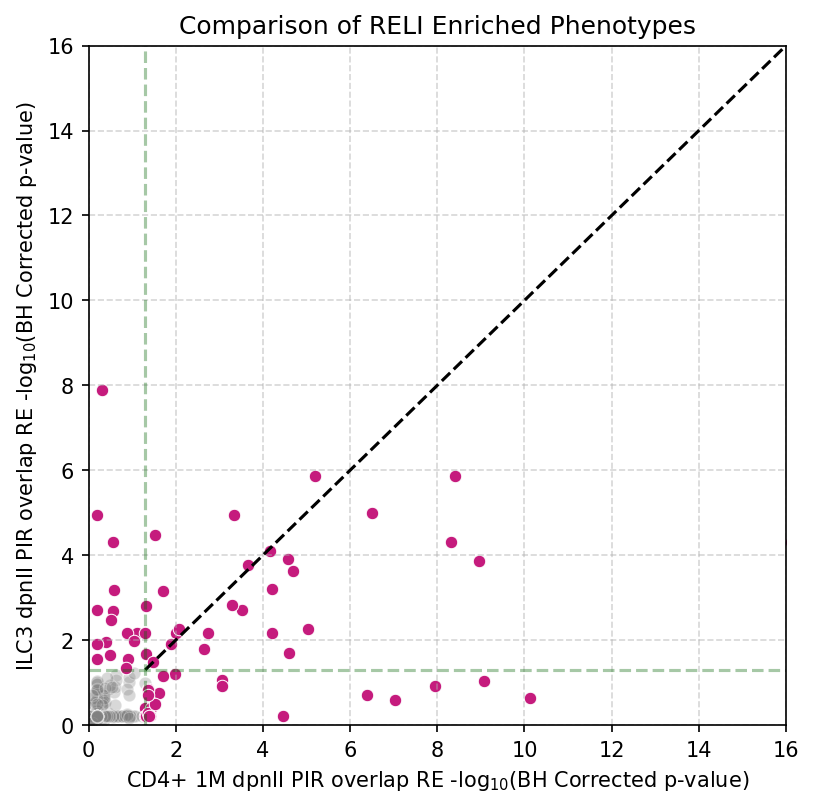

In [12]:
plt.figure(figsize=(6,6), dpi=150)

sns.scatterplot(data=table_1M_bh, 
                x="CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection", 
                y = "hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection",
                color="grey",
                alpha=.3
                )

ILC_above = table_1M_bh[table_1M_bh["hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection"] > -np.log10(.05)]

CD4_above = table_1M_bh[table_1M_bh["CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection"] > -np.log10(.05)]

sns.scatterplot(data=ILC_above, 
                x="CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection", 
                y = "hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection",
                color="#c51b7d"
                )

sns.scatterplot(data=CD4_above, 
                x="CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection", 
                y = "hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection",
                color="#c51b7d"
                )

plt.xlim(0,16)
plt.ylim(0,16)
plt.plot([-np.log10(.05),20], [-np.log10(.05),20], color="k", ls='--')

plt.grid(which="both", alpha=.5, ls="--")
plt.title("Comparison of RELI Enriched Phenotypes")

plt.vlines(x=-np.log10(.05), ymin=0,ymax=20, color="darkgreen", linestyle="--", alpha=.35)
plt.hlines(y=-np.log10(.05), xmin=0,xmax=20, color="darkgreen", linestyle="--", alpha=.35)

plt.xlabel("CD4+ 1M dpnII PIR overlap RE -log$_{10}$(BH Corrected p-value)")
plt.ylabel("ILC3 dpnII PIR overlap RE -log$_{10}$(BH Corrected p-value)")

plt.savefig("/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/RELI_final/RELI_ILC3_CD4_BH_fdr5percent_pvalue_neglog10.png")

In [20]:
table_1M_bh.to_csv("/Users/caz3so/scratch/20220428_RELI_spivakov_rerun/output/RELI/RELI_final/20220526_spivakov_ILC3_CD4_1M_RELI_763phenotypes_results.tsv", sep="\t", index=False)

In [182]:
import plotly.express as px
px.scatter(table_1M_bh, x="CD4_1M_dpnII_5kbin_PIR_overlapRE_intersection", y="hILC3_10K_dpnII_5kbin_PIR_overlapRE_intersection",
                hover_data=['disease'])